<div style="display: flex; background-color: RGB(255,114,0);" >
<h1 style="margin: auto; padding: 30px; ">Freight value prediction</h1>
</div>


<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Partie 1 -Nettoyage des données</h2>
</div>

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">1.1 - Import des librairies</h3>
</div>

In [204]:
import pandas as pd
import numpy as np
from geopy import distance
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact
from scipy.stats import spearmanr, ttest_1samp, ttest_ind, shapiro, f_oneway
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNet
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">1.2 - Récuperation des fichiers </h3>
</div>

In [205]:
customers = pd.read_csv("olist_customers_dataset.csv")
orders = pd.read_csv("olist_orders_dataset.csv")
items = pd.read_csv("olist_order_items_dataset.csv")
payments = pd.read_csv("olist_order_payments_dataset.csv")
reviews = pd.read_csv("olist_order_reviews_dataset.csv")
geolocations = pd.read_csv("olist_geolocation_dataset.csv")
sellers = pd.read_csv("olist_sellers_dataset.csv")
products = pd.read_csv("olist_products_dataset.csv")
name_translations = pd.read_csv("product_category_name_translation.csv")

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">1.3 - Merge des données  </h3>
</div>

In [206]:
# Merge de tout les tableaux en un grand tableau à 40 colonnes 
data = customers.merge(orders, on = 'customer_id')\
                .merge(items, on = 'order_id')\
                .merge(payments, on = 'order_id')\
                .merge(reviews, on = 'order_id')\
                .merge(products, on = 'product_id')\
                .merge(name_translations, on = 'product_category_name')\
                .merge(sellers, on = 'seller_id')
data

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,seller_zip_code_prefix,seller_city,seller_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,...,1141.0,1.0,8683.0,54.0,64.0,31.0,office_furniture,8577,itaquaquecetuba,SP
1,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,2017-11-10 00:47:48,2017-11-22 01:43:37,...,1141.0,1.0,8683.0,54.0,64.0,31.0,office_furniture,8577,itaquaquecetuba,SP
2,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,2017-11-10 00:47:48,2017-11-22 01:43:37,...,1141.0,1.0,8683.0,54.0,64.0,31.0,office_furniture,8577,itaquaquecetuba,SP
3,f0ac8e5a239118859b1734e1087cbb1f,3c799d181c34d51f6d44bbbc563024db,92480,nova santa rita,RS,b1a5d5365d330d10485e0203d54ab9e8,delivered,2017-05-07 20:11:26,2017-05-08 22:22:56,2017-05-19 20:16:31,...,1141.0,1.0,8683.0,54.0,64.0,31.0,office_furniture,8577,itaquaquecetuba,SP
4,6bc8d08963a135220ed6c6d098831f84,23397e992b09769faf5e66f9e171a241,25931,mage,RJ,2e604b3614664aa66867856dba7e61b7,delivered,2018-02-03 19:45:40,2018-02-04 22:29:19,2018-02-19 18:21:47,...,1141.0,1.0,8683.0,54.0,64.0,31.0,office_furniture,8577,itaquaquecetuba,SP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115604,ce2172509c4149d65212484eb761bc37,c5da6424f1f5decedef8672a1a0103e1,88350,brusque,SC,edcf1e1eeb52381be9388c90152be52d,delivered,2018-08-21 11:29:05,2018-08-21 11:50:47,2018-08-21 15:37:00,...,1002.0,3.0,1900.0,19.0,16.0,16.0,arts_and_craftmanship,95910,lajeado,RS
115605,ee1cfdc92e449920e25d3ca4ab4da4f6,8d80e477643ec569b24592ce3d9dfc4c,9951,diadema,SP,2ef4a11b6e24fdfbb43b92cb5f95edff,delivered,2018-07-23 18:35:14,2018-07-24 10:31:25,2018-07-24 14:37:00,...,660.0,3.0,500.0,16.0,6.0,16.0,arts_and_craftmanship,17201,jau,SP
115606,ee1cfdc92e449920e25d3ca4ab4da4f6,8d80e477643ec569b24592ce3d9dfc4c,9951,diadema,SP,2ef4a11b6e24fdfbb43b92cb5f95edff,delivered,2018-07-23 18:35:14,2018-07-24 10:31:25,2018-07-24 14:37:00,...,942.0,5.0,500.0,21.0,7.0,14.0,arts_and_craftmanship,17201,jau,SP
115607,ab0cf72dfe0538a63a57d6905ccb7b57,8c3c961a52bb5a0ffbce1d4e6d25cd67,35930,joao monlevade,MG,2c12150c742ae2fa48bc703964c16c5f,delivered,2018-07-28 17:55:27,2018-07-29 18:30:31,2018-07-30 14:54:00,...,923.0,5.0,1000.0,25.0,25.0,25.0,arts_and_craftmanship,17201,jau,SP


<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">1.4 - Rassemblement des données utiles </h3>
</div>

On récupère les données importantes pour une commande et les positionnent dans un dataframe

In [207]:
df_order = data[['order_id','order_purchase_timestamp','order_item_id','product_id','price','freight_value','customer_unique_id']]
df_order.head()

,order_id,order_purchase_timestamp,order_item_id,product_id,price,freight_value,customer_unique_id
0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,1,a9516a079e37a9c9c36b9b78b10169e8,124.99,21.88,861eff4711a542e4b93843c6dd7febb0
1,c1d2b34febe9cd269e378117d6681172,2017-11-09 00:50:13,1,a9516a079e37a9c9c36b9b78b10169e8,112.99,24.90,9eae34bbd3a474ec5d07949ca7de67c0
2,c1d2b34febe9cd269e378117d6681172,2017-11-09 00:50:13,2,a9516a079e37a9c9c36b9b78b10169e8,112.99,24.90,9eae34bbd3a474ec5d07949ca7de67c0
3,b1a5d5365d330d10485e0203d54ab9e8,2017-05-07 20:11:26,1,a9516a079e37a9c9c36b9b78b10169e8,124.99,15.62,3c799d181c34d51f6d44bbbc563024db
4,2e604b3614664aa66867856dba7e61b7,2018-02-03 19:45:40,1,a9516a079e37a9c9c36b9b78b10169e8,106.99,30.59,23397e992b09769faf5e66f9e171a241


In [208]:
df_customer = data[['customer_id','customer_unique_id','customer_zip_code_prefix','customer_city','customer_state']]
df_customer

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA
2,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA
3,f0ac8e5a239118859b1734e1087cbb1f,3c799d181c34d51f6d44bbbc563024db,92480,nova santa rita,RS
4,6bc8d08963a135220ed6c6d098831f84,23397e992b09769faf5e66f9e171a241,25931,mage,RJ
...,...,...,...,...,...
115604,ce2172509c4149d65212484eb761bc37,c5da6424f1f5decedef8672a1a0103e1,88350,brusque,SC
115605,ee1cfdc92e449920e25d3ca4ab4da4f6,8d80e477643ec569b24592ce3d9dfc4c,9951,diadema,SP
115606,ee1cfdc92e449920e25d3ca4ab4da4f6,8d80e477643ec569b24592ce3d9dfc4c,9951,diadema,SP
115607,ab0cf72dfe0538a63a57d6905ccb7b57,8c3c961a52bb5a0ffbce1d4e6d25cd67,35930,joao monlevade,MG


On enlèves les lignes ayant des valeurs nulles dans notre dataframa

In [209]:
data.dropna(axis = 0, inplace = True)

On réalise la même chose sur le dataset des géolocalisations pour obtenir des zip code uniques 

In [210]:
geolocations.dropna(inplace=True)
geolocations.drop_duplicates(subset="geolocation_zip_code_prefix",inplace=True)
geolocations.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP
5,1012,-23.547762,-46.635361,são paulo,SP


Cela nous permet donc de merge nos dataframe geolocalisation et df_customer pour ainsi obtenir la position du client 

In [211]:
df_customer = df_customer.merge(geolocations, left_on="customer_zip_code_prefix", 
                                right_on="geolocation_zip_code_prefix", how="left")

In [212]:
df_customer = df_customer[["customer_id","customer_unique_id","customer_zip_code_prefix","customer_city"
                           ,"customer_state","geolocation_lat","geolocation_lng"]]
df_customer.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_lat,geolocation_lng
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,-20.509897,-47.397866
1,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,-2.442747,-54.728950
2,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,-2.442747,-54.728950
3,f0ac8e5a239118859b1734e1087cbb1f,3c799d181c34d51f6d44bbbc563024db,92480,nova santa rita,RS,-29.856534,-51.268958
4,6bc8d08963a135220ed6c6d098831f84,23397e992b09769faf5e66f9e171a241,25931,mage,RJ,-22.627556,-43.159942


On récupère des positions uniques pour chaque client 

In [213]:
cust_locs = df_customer[[
    'customer_unique_id',
    'geolocation_lat',
    'geolocation_lng'
]].groupby('customer_unique_id').mean().reset_index()
cust_locs.head(5)

,customer_unique_id,geolocation_lat,geolocation_lng
0,0000366f3b9a7992bf8c76cfdf3221e2,-23.335331,-46.828647
1,0000b849f77a49e4a4ce2b2a4ca5be3f,-23.567395,-46.792957
2,0000f46a3911fa3c0805444483337064,-27.543787,-48.625680
3,0000f6ccb0745a6a4b88665a16c9f078,-1.311011,-48.482884
4,0004aac84e0df4da2b147fca70cf8255,-23.504368,-47.466156


On merge les dataframes order et client pour ainsi avoir la commande 

In [214]:
order_customer_loc = pd.merge(
    left= df_order,
    right= cust_locs,
    on= 'customer_unique_id',
    how= 'left'
).rename(columns= {'geolocation_lat':'cust_lat', 'geolocation_lng':'cust_lng'})[[
    'order_id',
    'customer_unique_id',
    'cust_lat',
    'cust_lng'
]]
order_customer_loc.head()

,order_id,customer_unique_id,cust_lat,cust_lng
0,00e7ee1b050b8499577073aeb2a297a1,861eff4711a542e4b93843c6dd7febb0,-20.509897,-47.397866
1,c1d2b34febe9cd269e378117d6681172,9eae34bbd3a474ec5d07949ca7de67c0,-2.442747,-54.728950
2,c1d2b34febe9cd269e378117d6681172,9eae34bbd3a474ec5d07949ca7de67c0,-2.442747,-54.728950
3,b1a5d5365d330d10485e0203d54ab9e8,3c799d181c34d51f6d44bbbc563024db,-29.856534,-51.268958
4,2e604b3614664aa66867856dba7e61b7,23397e992b09769faf5e66f9e171a241,-22.627556,-43.159942


In [215]:
df_order_items = data[["order_id","order_item_id","product_id","seller_id"
                       ,"shipping_limit_date","price","freight_value"]]
df_order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
44,64a9f2b487f66506d463ca18152280e8,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2018-03-09 09:47:40,116.99,18.53
45,54d6f9d8f56229d3da815add65ec2408,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2018-04-05 11:15:35,116.99,57.08
46,54d6f9d8f56229d3da815add65ec2408,2,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2018-04-05 11:15:35,116.99,57.08
57,626434e11c37535d5f24e9d844249b55,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2018-04-19 02:15:14,116.99,57.08
58,626434e11c37535d5f24e9d844249b55,2,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2018-04-19 02:15:14,116.99,57.08


On repète maintenant les premières étapes mais cette fois ci pour les vendeurs 

In [200]:
sellers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [218]:
df_seller = sellers.merge(geolocations, left_on="seller_zip_code_prefix", right_on="geolocation_zip_code_prefix", how="left")
df_seller.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,13023.0,-22.898536,-47.063125,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP,13844.0,-22.382941,-46.946641,mogi-guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ,20031.0,-22.910641,-43.176510,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP,4195.0,-23.657250,-46.610759,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP,12914.0,-22.971648,-46.533618,bragança paulista,SP


In [219]:
df_seller.rename(columns={"geolocation_lat" : "seller_lat", "geolocation_lng" : "seller_lng"},inplace=True)
df_seller.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state,geolocation_zip_code_prefix,seller_lat,seller_lng,geolocation_city,geolocation_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,13023.0,-22.898536,-47.063125,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP,13844.0,-22.382941,-46.946641,mogi-guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ,20031.0,-22.910641,-43.176510,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP,4195.0,-23.657250,-46.610759,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP,12914.0,-22.971648,-46.533618,bragança paulista,SP


In [220]:
sell_loc = df_seller[[
    'seller_id',
    'seller_lat',
    'seller_lng'
]].groupby('seller_id').mean().reset_index()
sell_loc.head()

,seller_id,seller_lat,seller_lng
0,0015a82c2db000af6aaaf3ae2ecb0532,-23.644439,-46.539885
1,001cca7ae9ae17fb1caed9dfb1094831,-20.297537,-40.400869
2,001e6ad469a905060d959994f1b41e4f,-22.874040,-43.033089
3,002100f778ceb8431b7a1020ff7ab48f,-20.506794,-47.407738
4,003554e2dce176b5555353e4f3555ac8,-16.648412,-49.311191


In [221]:
sell_order_loc = pd.merge(
    left= df_order_items,
    right= sell_loc,
    on= 'seller_id',
    how= 'left'
)[[
    'order_id',
    'product_id',
    'seller_id',
    'freight_value',
    'seller_lat',
    'seller_lng',
    'price'
]]
sell_order_loc.head()

,order_id,product_id,seller_id,freight_value,seller_lat,seller_lng,price
0,64a9f2b487f66506d463ca18152280e8,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,18.53,-23.482623,-46.37449,116.99
1,54d6f9d8f56229d3da815add65ec2408,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,57.08,-23.482623,-46.37449,116.99
2,54d6f9d8f56229d3da815add65ec2408,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,57.08,-23.482623,-46.37449,116.99
3,626434e11c37535d5f24e9d844249b55,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,57.08,-23.482623,-46.37449,116.99
4,626434e11c37535d5f24e9d844249b55,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,57.08,-23.482623,-46.37449,116.99


On rassemble toutes les données 

In [222]:
order_cust_sel_loc = pd.merge(
    left= order_customer_loc,
    right= sell_order_loc,
    on= 'order_id',
    how= 'inner'
).drop_duplicates()
order_cust_sel_loc.head()

,order_id,customer_unique_id,cust_lat,cust_lng,product_id,seller_id,freight_value,seller_lat,seller_lng,price
0,64a9f2b487f66506d463ca18152280e8,c666e59a2d3ced923880461526113d38,-23.613644,-46.600791,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,18.53,-23.482623,-46.37449,116.99
1,54d6f9d8f56229d3da815add65ec2408,b52b8debdefe66d4c0d7f44d9b4ff088,-22.765556,-41.899277,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,57.08,-23.482623,-46.37449,116.99
5,626434e11c37535d5f24e9d844249b55,5bd86f8bd79bd3de2c99a5af1699b6a1,-19.923879,-40.861983,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,57.08,-23.482623,-46.37449,116.99
14,cd74cd8f3a1445a29e098dcac4cc8d11,c1d6b3acce320f7fe811d54554febfd4,-22.927115,-43.173630,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,36.28,-23.482623,-46.37449,149.98
18,665d84d48d4c7c497117465e6f02f92f,71c98a01b26884386e5c68ac5b09054a,-23.742926,-46.710060,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,26.10,-23.482623,-46.37449,159.98


In [223]:
df_product = products[['product_id','product_category_name','product_name_lenght','product_description_lenght','product_photos_qty','product_weight_g','product_length_cm','product_height_cm','product_width_cm']]
df_product.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


On forme une dataframe final pour les analyses predictives en ajoutant les colonnes les plus importantes comme les dimensions , les coordonnées et le poids 

In [224]:
df = pd.merge(
    left= order_cust_sel_loc,
    right= df_product,
    on= 'product_id',
    how= 'left'
)[[
    'order_id',
    'customer_unique_id',
    'product_id',
    'seller_id',
    'cust_lat',
    'cust_lng',
    'seller_lat',
    'seller_lng',
    'product_category_name',
    'product_weight_g',
    'product_length_cm',
    'product_height_cm',
    'product_width_cm',
    'price',
    'freight_value'
]]
df.head()


,order_id,customer_unique_id,product_id,seller_id,cust_lat,cust_lng,seller_lat,seller_lng,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm,price,freight_value
0,64a9f2b487f66506d463ca18152280e8,c666e59a2d3ced923880461526113d38,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,-23.613644,-46.600791,-23.482623,-46.37449,moveis_escritorio,8683.0,54.0,64.0,31.0,116.99,18.53
1,54d6f9d8f56229d3da815add65ec2408,b52b8debdefe66d4c0d7f44d9b4ff088,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,-22.765556,-41.899277,-23.482623,-46.37449,moveis_escritorio,8683.0,54.0,64.0,31.0,116.99,57.08
2,626434e11c37535d5f24e9d844249b55,5bd86f8bd79bd3de2c99a5af1699b6a1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,-19.923879,-40.861983,-23.482623,-46.37449,moveis_escritorio,8683.0,54.0,64.0,31.0,116.99,57.08
3,cd74cd8f3a1445a29e098dcac4cc8d11,c1d6b3acce320f7fe811d54554febfd4,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,-22.927115,-43.173630,-23.482623,-46.37449,moveis_escritorio,8267.0,52.0,52.0,17.0,149.98,36.28
4,665d84d48d4c7c497117465e6f02f92f,71c98a01b26884386e5c68ac5b09054a,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,-23.742926,-46.710060,-23.482623,-46.37449,moveis_escritorio,12160.0,56.0,51.0,28.0,159.98,26.10


On calcule la distance entre les clients et les vendeurs 

In [225]:
def calc_dist(cust,sel):
    return distance.geodesic(cust,sel).km

df.dropna(subset= [
    'cust_lat',
    'cust_lng',
    'seller_lat',
    'seller_lng'
], inplace= True)

df['distance'] = df[[
    'cust_lat',
    'cust_lng',
    'seller_lat',
    'seller_lng'
]].apply(lambda row: calc_dist((row.cust_lat,row.cust_lng),(row.seller_lat,row.seller_lng)), axis=1)

df.head()

,order_id,customer_unique_id,product_id,seller_id,cust_lat,cust_lng,seller_lat,seller_lng,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm,price,freight_value,distance
0,64a9f2b487f66506d463ca18152280e8,c666e59a2d3ced923880461526113d38,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,-23.613644,-46.600791,-23.482623,-46.37449,moveis_escritorio,8683.0,54.0,64.0,31.0,116.99,18.53,27.284813
1,54d6f9d8f56229d3da815add65ec2408,b52b8debdefe66d4c0d7f44d9b4ff088,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,-22.765556,-41.899277,-23.482623,-46.37449,moveis_escritorio,8683.0,54.0,64.0,31.0,116.99,57.08,465.195316
2,626434e11c37535d5f24e9d844249b55,5bd86f8bd79bd3de2c99a5af1699b6a1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,-19.923879,-40.861983,-23.482623,-46.37449,moveis_escritorio,8683.0,54.0,64.0,31.0,116.99,57.08,693.146796
3,cd74cd8f3a1445a29e098dcac4cc8d11,c1d6b3acce320f7fe811d54554febfd4,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,-22.927115,-43.173630,-23.482623,-46.37449,moveis_escritorio,8267.0,52.0,52.0,17.0,149.98,36.28,333.379916
4,665d84d48d4c7c497117465e6f02f92f,71c98a01b26884386e5c68ac5b09054a,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,-23.742926,-46.710060,-23.482623,-46.37449,moveis_escritorio,12160.0,56.0,51.0,28.0,159.98,26.10,44.765253


On ajoute le volume pour transformer nos 3 colonnes en une seule 

In [202]:
df['volume_cm3'] = df.product_height_cm * df.product_length_cm * df.product_width_cm
df.head()

,order_id,customer_unique_id,product_id,seller_id,cust_lat,cust_lng,seller_lat,seller_lng,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm,price,freight_value,distance,volume_cm3
0,64a9f2b487f66506d463ca18152280e8,c666e59a2d3ced923880461526113d38,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,-23.613644,-46.600791,-23.482623,-46.37449,moveis_escritorio,8683.0,54.0,64.0,31.0,116.99,18.53,27.284813,107136.0
1,54d6f9d8f56229d3da815add65ec2408,b52b8debdefe66d4c0d7f44d9b4ff088,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,-22.765556,-41.899277,-23.482623,-46.37449,moveis_escritorio,8683.0,54.0,64.0,31.0,116.99,57.08,465.195316,107136.0
2,626434e11c37535d5f24e9d844249b55,5bd86f8bd79bd3de2c99a5af1699b6a1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,-19.923879,-40.861983,-23.482623,-46.37449,moveis_escritorio,8683.0,54.0,64.0,31.0,116.99,57.08,693.146796,107136.0
3,cd74cd8f3a1445a29e098dcac4cc8d11,c1d6b3acce320f7fe811d54554febfd4,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,-22.927115,-43.173630,-23.482623,-46.37449,moveis_escritorio,8267.0,52.0,52.0,17.0,149.98,36.28,333.379916,45968.0
4,665d84d48d4c7c497117465e6f02f92f,71c98a01b26884386e5c68ac5b09054a,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,-23.742926,-46.710060,-23.482623,-46.37449,moveis_escritorio,12160.0,56.0,51.0,28.0,159.98,26.10,44.765253,79968.0


<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">Partie 2 - Analyse features importantes </h2>
</div>

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">2.1 - Visualisation de la distribution </h3>
</div>

Pour l'analyse les feature choisis sont le poids , la longueur , la hauteur , la largeur , la distance , le volume et le prix qui seront ainsi comparées au frais de port (label)

In [173]:
@interact
def plot_hist(
    column= ['product_weight_g', 'product_length_cm',
            'product_height_cm','product_width_cm',
            'distance','volume_cm3', 'freight_value', 'price']
):
    plt.figure(figsize= (12,8))
    sns.distplot(df[column], kde= True)
    plt.title('Histogram of {}'.format(column), fontdict= {'size':15})

interactive(children=(Dropdown(description='column', options=('product_weight_g', 'product_length_cm', 'produc…

Nous pouvons remarquer que toutes les courbes sont positives 

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">2.2 - Visualisation de la corrélation </h3>
</div>

In [226]:
df.corr(method='pearson')

,cust_lat,cust_lng,seller_lat,seller_lng,product_weight_g,product_length_cm,product_height_cm,product_width_cm,price,freight_value,distance
cust_lat,1.000000,0.468820,0.111440,0.126505,-0.007423,-0.021350,-0.009783,-0.023737,0.074868,0.290943,0.709164
cust_lng,0.468820,1.000000,0.083224,0.116526,-0.012163,-0.028457,-0.031598,-0.009930,0.025203,0.097969,0.272506
seller_lat,0.111440,0.083224,1.000000,0.458301,-0.037405,-0.034075,-0.043177,-0.032371,0.025092,0.059733,0.209117
seller_lng,0.126505,0.116526,0.458301,1.000000,-0.014561,-0.068933,-0.012538,-0.069101,0.063353,-0.001439,0.029256
product_weight_g,-0.007423,-0.012163,-0.037405,-0.014561,1.000000,0.543568,0.596332,0.530708,0.341085,0.596988,-0.020160
product_length_cm,-0.021350,-0.028457,-0.034075,-0.068933,0.543568,1.000000,0.245531,0.605952,0.188714,0.384606,-0.013579
product_height_cm,-0.009783,-0.031598,-0.043177,-0.012538,0.596332,0.245531,1.000000,0.291337,0.214936,0.371523,-0.007481
product_width_cm,-0.023737,-0.009930,-0.032371,-0.069101,0.530708,0.605952,0.291337,1.000000,0.176199,0.357811,-0.028299
price,0.074868,0.025203,0.025092,0.063353,0.341085,0.188714,0.214936,0.176199,1.000000,0.419524,0.093544
freight_value,0.290943,0.097969,0.059733,-0.001439,0.596988,0.384606,0.371523,0.357811,0.419524,1.000000,0.408608


<AxesSubplot:>

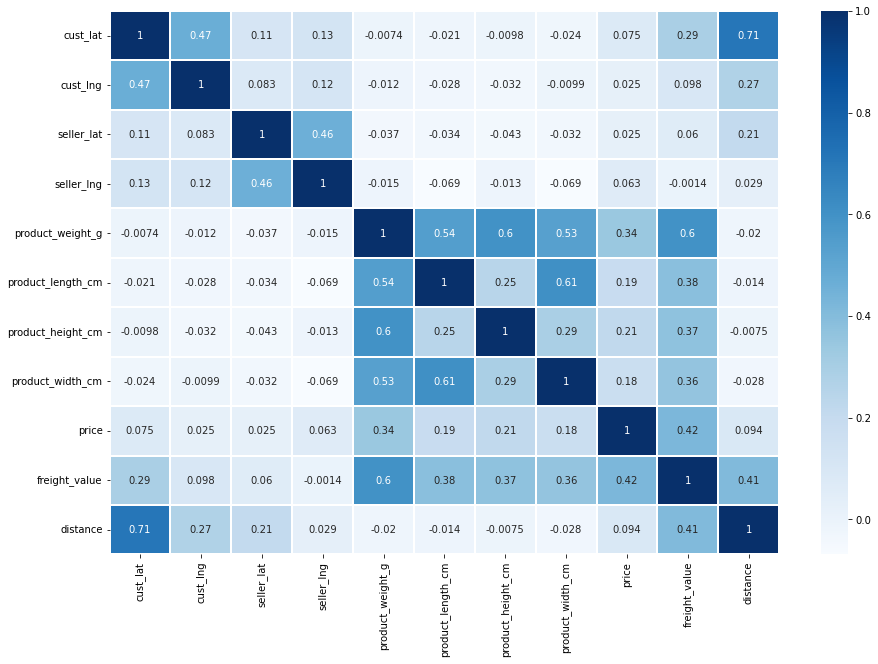

In [227]:
corr = df.corr()
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(corr, cmap="Blues", annot=True, linewidths=.1)

Observations :

- les dimemsions du produit ont une corrélation positive entre 0.3 et 0.4
- la distance et la feature ayant une corrélation similaire que les dimensions à 0.41
- le poids et le volume sont les features ayant les corrélations les plus élevées à 0.6
